In [1]:
# FLAGS

TESTING = True
VERBOSE = False

In [2]:
import os, pickle, random
from pathlib import Path

import networkx as nx
import numpy as np

Load embeddings of graph, edges, and sentences (for novelty)

In [3]:
# Embedding-based diversity (NOVELTY SCORES)
try:
    from sentence_transformers import SentenceTransformer
    model_name, embedding_dimension = "all-MiniLM-L6-v2", 384
    embedder = SentenceTransformer(model_name)

    def embed(text: str) -> np.ndarray:
        return embedder.encode(text, normalize_embeddings=True) # normalize for cosine distance calculation
    print(f"Loaded {model_name} for embeddings")
except ImportError:
    embedder = None
    def embed(text: str) -> np.ndarray:
        return np.random.rand(384) # fallback
    print("⚠ SentenceTransformer not available; using random embeddings")

Loaded all-MiniLM-L6-v2 for embeddings


In [4]:
# Load Graph and Embeddings
DATA_DIR  = Path("data/GRAPHDATA")
GRAPH_FN  = DATA_DIR / "graph.graphml"
EMB_FN    = DATA_DIR / "node_embeddings.pkl"

if not GRAPH_FN.exists():
    raise FileNotFoundError(f"Missing graph file at {GRAPH_FN}")
G = nx.read_graphml(GRAPH_FN)
print(f"Loaded {type(G).__name__} with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# Load embeddings
if not EMB_FN.exists():
    raise FileNotFoundError(f"Missing embeddings file at {EMB_FN}")
with open(EMB_FN, "rb") as f:
    node_embeddings = pickle.load(f)
print(f"Loaded embeddings for {len(node_embeddings)} nodes")

Loaded Graph with 12319 nodes and 15752 edges
Loaded embeddings for 12319 nodes


In [37]:
def linearise_triples(graph: nx.MultiDiGraph, path: list[str]) -> str:
    """ Convert sequence of nodes into readable chain | e.g. A -[rel]-> B  →  B -[rel]-> C  →  …"""
    parts = []
    for u, v in zip(path[:-1], path[1:]):
        data = graph.get_edge_data(u, v)
        if data and "title" in data:
            rel = data["title"] # next(iter(data.values()))
        else:
            rel = 'related_to'
        parts.append(f"{u} -[{rel}]-> {v}")
    return " · ".join(parts)

if TESTING:
    source, target = "spider silk", "metals"
    try:
        sp = nx.shortest_path(G, source, target)
        print("Shortest path noes:", sp)
        print("Linearised:", linearise_triples(G, sp))
    except nx.NetworkXNoPath:
        print(f"No path between {source!r} and {target!r}")

Shortest path noes: ['spider silk', 'biological materials', 'failure', 'dislocations', 'metals']
Linearised: spider silk -[is an example of]-> biological materials · biological materials -[is defined as a sudden loss of function or capacity to provide service during expected lifetime]-> failure · failure -[occurs through]-> dislocations · dislocations -[have an orderly face-centered cubic crystal structure]-> metals


Random Walk Path Sampler

In [77]:
import random, heapq
from typing import List, Tuple, Optional, Callable

# Ensure source/target anchor exist, else pick random nodes
def pick_anchors(G: nx.Graph, source: Optional[str], target: Optional[str]) -> Tuple[str, str]:
    nodes = list(G.nodes())
    if source not in G or target not in G:
        a, b = random.sample(nodes, 2)
        print(f"[DEBUG] sampled '{a}', '{b}'")
        return a, b
    return source, target

# Heuristic distance function (euclidean distance between embeddings)
def embedding_distance(u: str, v: str, embeddings: dict[str, np.ndarray]) -> float:
    du = embeddings[u]
    dv = embeddings[v]
    return float(np.linalg.norm(du - dv))

# Dijksta-like search return first path that reaches target. Uses embedding distance heuristic and randomness factor
def biased_path_dijkstra(G: nx.Graph, source: str, target: str, embeddings: dict[str, np.ndarray], alpha: float = 0.2) -> Optional[List[str]]:
    # Min heap of (priority, cost_so_far, current_node, path_so_far)
    heap: List[Tuple[float, int, str, List[str]]] = []

    # Initial heuristic estimate
    h0 = embedding_distance(source, target, embeddings)
    heapq.heappush(heap, (h0, 0, source, [source]))
    visited = set()

    while heap:
        _priority, cost, u, path = heapq.heappop(heap)
        if u == target: return path
        if u in visited: continue
        visited.add(u)

        for v in G.neighbors(u):
            if v in visited: continue
            cw = cost + G.edges[u, v].get("width", 1)
            heuristic = embedding_distance(v, target, embeddings)

            # Randomised
            pri = cw + heuristic + alpha * random.random()
            heapq.heappush(heap, (pri, cw, v, path + [v]))

    return None     # No path found


# Given a base_path from source to target, sample num_waypoints as neighbours of route and stitch them in via shortest_path sublegs
def add_random_waypoints(G: nx.Graph, base_path: List[str], num_waypoints: int) -> List[str]:
    candidates = []
    for u in base_path:
        for neighbour in G.neighbors(u):
            if neighbour not in base_path:
                candidates.append(neighbour)
    random.shuffle(candidates)
    waypoints = candidates[:num_waypoints]

    # Build new path from source
    new_path = [base_path[0]]
    previous = base_path[0]
    for waypoint in waypoints:
        try:
            detour = nx.shortest_path(G, previous, waypoint)
        except nx.NetworkXNoPath:
            continue

        new_path += detour[1:]        # Append leg (without previous)
        previous = waypoint
    
    # Final leg to original target
    original_target = base_path[-1]
    try:
        final_leg = nx.shortest_path(G, previous, original_target)
        new_path += final_leg[1:]
    except nx.NetworkXNoPath:
        new_path.append(original_target)
    
    if VERBOSE: 
        print(f"[DEBUG]\n old_path = {base_path}\n new_path = {new_path}\n")
    return new_path

In [78]:
# Mean-node embeddings
def path_embedding(path: List[str], embed: Callable[[str], np.ndarray]) -> np.ndarray:
    vectors = [embed(node) for node in path]
    matrix = np.stack(vectors, axis=0) # (N_nodes, 384)
    average = matrix.mean(axis=0)
    
    norm = np.linalg.norm(average)
    if norm > 0: average /= norm
    return average

# Choise k paths that are as 'diverse' as possible using greedy farthest-first heuristic on cosine distance between path embeddings
def select_diverse(paths: List[List[str]], embed: Callable[[str], np.ndarray], k: int) -> List[List[str]]:
    n = len(paths)
    if n == 0 or k <= 0: return []

    path_embeddings = [path_embedding(path, embed) for path in paths]
    selected_indices = [0]
    for _ in range(min(k - 1, n - 1)):
        best_index, best_score = None, -1.0
        for i in range(n):
            if i in selected_indices: continue

            # Compute min cosine distance to any already chosen
            distances = []
            for j in selected_indices:
                sim = np.dot(path_embeddings[i], path_embeddings[j]) # [-1, 1]
                distances.append(1 - sim)
            min_dist = min(distances) if distances else 0.0
            if min_dist > best_score:
                best_score = min_dist
                best_index = i
        if best_index is None: break
        selected_indices.append(best_index)
    
    return [paths[i] for i in selected_indices]

if TESTING:     # select_diverse()
    rng = np.random.RandomState(0)
    def dummy_embed(s: str) -> np.ndarray:
        rng.seed(hash(s) % 2**32)
        v = rng.rand(128)
        return v / np.linalg.norm(v)

    # Three toy paths
    toy_paths = [
        ["Apple", "Banana", "C", "Dinosaur"],
        ["A", "X", "Y", "Dinosaur"],
        ["A", "Banana", "Y", "D"],
        ["A", "Z", "Cumquat", "D"],
    ]

    for path in toy_paths:
        emb = path_embedding(path, dummy_embed)
        print(f"Path {path} -> embedding norm = {np.linalg.norm(emb):.3f}")

    # Select 2 diverse paths
    diverse = select_diverse(toy_paths, dummy_embed, k=3)
    print("\n Selected diverse paths:")
    for path in diverse:
        print(" ", path)


Path ['Apple', 'Banana', 'C', 'Dinosaur'] -> embedding norm = 1.000
Path ['A', 'X', 'Y', 'Dinosaur'] -> embedding norm = 1.000
Path ['A', 'Banana', 'Y', 'D'] -> embedding norm = 1.000
Path ['A', 'Z', 'Cumquat', 'D'] -> embedding norm = 1.000

 Selected diverse paths:
  ['Apple', 'Banana', 'C', 'Dinosaur']
  ['A', 'Z', 'Cumquat', 'D']
  ['A', 'X', 'Y', 'Dinosaur']


In [ ]:
def sample_biased_paths(G: nx.Graph, embeddings: dict[str, np.ndarray], source: Optional[str] = None, target: Optional[str] = None, alpha: float = 0.2,
                        num_waypoints: int = 2, attempts: int = 20, top_k: int = 5) -> List[List[str]]:
    src, tgt = pick_anchors(G, source or "", target or "")
    raw_paths: List[List[str]] = []
    for i in range(attempts):
        base = biased_path_dijkstra(G, src, tgt, embeddings, alpha)
        if base is None:
            continue
        if num_waypoints > 0:
            path = add_random_waypoints(G, base, num_waypoints)
        else:
            path = base
        raw_paths.append(path)
    
    # Ensure unique
    unique = []
    seen = set()
    for path in raw_paths:
        tup = tuple(path)
        if tup in seen:
            continue
        seen.add(tup)
        unique.append(tup)
    
    # Rank diversity
    return select_diverse(unique, embed, k=top_k)

if TESTING:     # sample_biased_paths() 
    random.seed(52)
    # source, target = "spider silk", "metals"
    # print(f"\nSampling biased paths from {source!r} to {target!r}…")

    paths = sample_biased_paths(G, node_embeddings, None, None, alpha=0.2, num_waypoints=0, attempts=100, top_k=3)
    print(f" Collected {len(paths)} unique paths:")
    for i, path in enumerate(paths, 1):
        print(f"Path #{i}: {linearise_triples(G, path)}")

[DEBUG] sampled 'bone structures', 'native oxide layers'
 Collected 4 unique paths:
Path #1: bone structures -[allows for]-> gradient properties · gradient properties -[have]-> fgms · fgms -[depend on]-> mechanical properties · mechanical properties -[show]-> materials · materials -[is defined as a sudden loss of function or capacity to provide service during expected lifetime]-> failure · failure -[can lead to]-> adhesive force · adhesive force -[did not change with]-> pfpe films · pfpe films -[were investigated for]-> silicon-on-silicon contacts · silicon-on-silicon contacts -[have]-> native oxide layers
Path #2: bone structures -[allows for]-> gradient properties · gradient properties -[have]-> fgms · fgms -[depend on]-> mechanical properties · mechanical properties -[provide functionalities]-> biological materials · biological materials -[is defined as a sudden loss of function or capacity to provide service during expected lifetime]-> failure · failure -[can lead to]-> adhesive fo

#### Node Embeddings Exploration

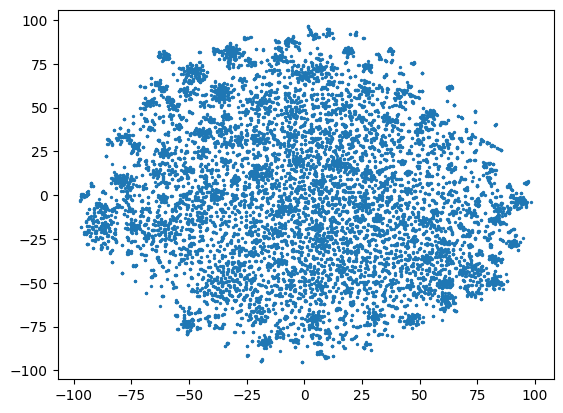

In [5]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

X = np.vstack(list(node_embeddings.values()))
labels = list(node_embeddings.keys())

tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)

import matplotlib.pyplot as plt
plt.scatter(X_2d[:,0], X_2d[:,1], s=2)


In [6]:
from sklearn.cluster import KMeans

k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_ids = kmeans.fit_predict(X)

# Map back to node IDs
label_to_cluster = {label: cluster_id for label, cluster_id in zip(labels, cluster_ids)}

In [7]:
from collections import defaultdict, Counter

clusters = defaultdict(list)
for node, cluster_id in label_to_cluster.items():
    clusters[cluster_id].append(node)

for i, nodes in clusters.items():
    print(f"\nCluster {i}:")
    for word, count in Counter(nodes).most_common(10):
        print(f"  - {word}")



Cluster 8:
  - abg group
  - octa
  - omag
  - sf-c group
  - sf-mc group
  - oct
  - shells
  - oc defects
  - oc function
  - further research

Cluster 4:
  - biological tissues
  - biopsies
  - capillaries
  - growth factor secretion
  - red blood cells
  - area of neovascularization
  - angiogenesis
  - neovascularization
  - vascularization
  - cell behavior

Cluster 6:
  - bone regeneration
  - chitin-calcium carbonate composite microstructure
  - hydroxyapatite/chitin composites
  - snow crab shells
  - fluorapatite/chitin composites
  - apatite crystals
  - decalcification
  - bioceramics
  - cartilage zone
  - osteochondral defects

Cluster 7:
  - calcium ions
  - local active ions
  - phosphoric acid
  - fluoride ions
  - hcl
  - naoh
  - biodegradability
  - catalytic functionality
  - chemical performance functionality
  - paramagnetism

Cluster 9:
  - scaffold porosity
  - copolymer
  - produced fibrin-based hydrogels
  - fiber thickness
  - hydrogel degradation
  - chito